###  Get variance for each amt labeled sentence
> Variance for each (word pair, sentence pair) of each method (e.g., variance among 200 trees in RF).

#### 0 Randomly select 85% of the whole data to fit the following methods and repeat to get variance 
> Not in use <br>

#### 1 VT-RF variance
> 1.1 Fit VT-RF with 85% source sentences (exclude the current one) and 85% target sentences <br>
> 1.2 Get decision\_path and feature\_importances for source sentence and target sentence, each tree has a path, 200 trees in total, path with max and min probability <br>
> 1.3 Record probability of source sentence and target sentence <br>
> 1.3 Compute treatment effect of each pair of sentence, get variance for source and target sentence separately <br>

#### 2 CTF-RF variance
> 2.1 Fit source RF with 85% source sentences (exclude the current one), target RF with 85% target sentences <br>
> 2.2 Get decision\_path and feature\_importances for source sentence and target sentence, path with max and min probability <br>
> 2.3 Record probability of source sentence and target sentence <br>
> 2.3 Compute treatment effect of each pair of sentence, get variance for source and target sentence separately <br>

#### 3 CSF variance
> 3.1 Fit causal forest and get variance directly <br>
> 3.2 Calculate variance according to predicted probabilities <br>
> 3.3 Get_tree and variable importance <br>

#### 4 Evaluation
> 4.1 Plot treatment effect errorbar (max,mean,min) where x represents instance, y represents variance <br>
> 4.2 Boxplot where x represents p(x=1) and y represents variance for probabilities <br>

In [1]:
import pickle, pydot, random, re, ast, time
import pandas as pd
import numpy as np
from scipy.sparse import vstack
from sklearn.externals.six import StringIO 
from IPython.display import display
#from sklearn.datasets import load_iris
from sklearn import tree
from IPython.display import Image
from collections import Counter
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import rpy2
import rpy2.robjects as ro
from rpy2.robjects import r
from rpy2.robjects import Matrix
import rpy2.robjects.numpy2ri
from rpy2.robjects.vectors import Matrix
from rpy2.robjects.packages import importr
importr('grf')
rpy2.robjects.numpy2ri.activate()
import warnings
warnings.filterwarnings("ignore")

In [3]:
project_path = '/data/2/zwang/2018_S_WordTreatment/'
amt_path = '/data/2/zwang/2018_S_WordTreatment/V2_AMT/6_amt/'
full_name = {'yp':'Yelp','tw':'Twitter','airbnb':'Airbnb'}
data_file = {}
data_file['yp'] = project_path + 'V2_yelp/5_Select/yp_wdpair_sents_4effects_posinters_poscom1_bigramcheck_limit.pickle'
data_file['tw'] = project_path + 'V2_twitter/5_Select/tw_wdpair_sents_4effects_posinters_poscom1_bigramcheck_limit.pickle'
data_file['airbnb'] = project_path + 'V2_airbnb/5_Select/airbnb_wdpair_sents_4effects_posinters_poscom1_bigramcheck_limit_limitvocab.pickle'
vocab_file = project_path+'V2_airbnb/0_Data/common_wds.csv'

#### KNN analysis

In [4]:
def fit_KNN(X_src_tf,src_smp_lbs,X_tar_tf,tar_smp_lbs,X_test_tf,src_wdi_tf,tar_wdi_tf,min_sim):
    """
    Get 30 neighbors from target sentences, and 30 from source sentences, take difference to get treatment effect.
    """
    X_test_tf_ = X_test_tf[:]
    X_test_tf_[:,src_wdi_tf]=0
    
    src_sim = cosine_similarity(X_test_tf_,X_src_tf)
    tar_sim = cosine_similarity(X_test_tf_,X_tar_tf)

    KNN_srcp = []
    KNN_tarp = []
    KNN_effects = []
#     src_neighbors = []
#     tar_neighbors = []
    for i in range(X_test_tf.shape[0]):
        row_effects = []
        for knb in range(10,105,5):
            src_neighbor_idx = src_sim[i].argsort()[::-1][:min(knb,len(src_sim[i]))]
    #         src_neighbors.append(src_sim[i].argsort()[::-1])
    #         src_sim_list.append([src_sim[i][idx] for idx in src_neighbor_idx])
            src_neighbor_labels = [src_smp_lbs[idx] for idx in src_neighbor_idx if src_sim[i][idx] > min_sim ] 

            tar_neighbor_idx = tar_sim[i].argsort()[::-1][:min(knb,len(tar_sim[i]))]
    #         tar_neighbors.append(tar_sim[i].argsort()[::-1])
    #         tar_sim_list.append([tar_sim[i][idx] for idx in tar_neighbor_idx])
            tar_neighbor_labels = [tar_smp_lbs[idx] for idx in tar_neighbor_idx if tar_sim[i][idx] > min_sim ]

#            KNN_srcp.append(float('%.3f' % (np.mean(src_neighbor_labels))))
#            KNN_tarp.append(float('%.3f' % (np.mean(tar_neighbor_labels))))
            row_effects.append(float('%.3f' % (np.mean(tar_neighbor_labels) - np.mean(src_neighbor_labels))))
        KNN_effects.append(row_effects)
        
    return KNN_srcp,KNN_tarp,KNN_effects # (used for calculate variance)
    #return KNN_srcp,KNN_tarp,KNN_effects,src_sim[0],tar_sim[0],src_neighbors[0],tar_neighbors[0]

In [132]:
def comp_err_KNN(flag,data_file,source,target,sentence):
    """
    Calculate neighbors for one instance of: (source,target,sentence)
    """
    #amt_pd = pd.read_csv(amt_file)
    # Step 1, get all containing sentences
    current_sents = [sentence]
    all_src_sents, all_src_labels, all_tar_sents, all_tar_labels = get_containing_sents([source,target],data_file)

    # Step 2: exclude current sentences from containing sentences, for out-of-bag prediction.
    current_ids = [all_src_sents.index(cur_sent) for cur_sent in current_sents]
    src_train_sents = []
    src_train_labels = []
    for i in range(len(all_src_sents)):
        if(i not in current_ids):
            src_train_sents.append(all_src_sents[i])
            src_train_labels.append(all_src_labels[i])

    # Vectorize sentences
    if(flag == 'airbnb'):
        my_vocab = list(set(pd.read_csv(vocab_file).word.values))
    else:
        my_vocab = []

    X_src_ct,X_tar_ct,X_test_ct,X_src_tf,X_tar_tf,X_test_tf,ct_vec,tf_vec = vectorize_sents(src_train_sents,all_tar_sents,current_sents,my_vocab)

    src_wdi_ct = ct_vec.vocabulary_[source]
    src_wdi_tf = tf_vec.vocabulary_[source]
    tar_wdi_ct = ct_vec.vocabulary_[target]
    tar_wdi_tf = tf_vec.vocabulary_[target]

    # Step 3: Find neighbors
    KNN_srcp,KNN_tarp,KNN_effects,src_sim,tar_sim,src_neighbors,tar_neighbors = fit_KNN(X_src_tf,src_train_labels,X_tar_tf,all_tar_labels,X_test_tf,src_wdi_tf,tar_wdi_tf)  
    
    return src_sim,tar_sim

In [ ]:
# src_neighbors,src_train_sents,src_train_labels,src_sim,tar_sim,tar_neighbors,all_tar_sents,all_tar_labels,X_src_tf,X_tar_tf,X_test_tf,tf_vocab,my_vocab = comp_err_KNN(flag='yp',amt_file=amt_path+'results/yp_result_summary_nodummy.csv',data_file=data_file['yp'],
#              source='yummy', target='delicious',
#              sentence='Yummy yummy yummy !!')

In [156]:
def KNN_count_simi0():
    """
    A list of 30 neighbor similarities in control sentence set, and 30 in treatment sentence set.  
    """
    for dataset in ['yp','tw','airbnb']:
        print("Processing %s ..." % full_name[dataset])
        amt_pd = pd.read_csv(amt_path+'results/'+dataset+'_result_summary_nodummy.csv')
        res_file = project_path+'V2_'+full_name[dataset].lower()+'/8_Var/'+dataset+'_KNN_neighbor_sim.csv'
        
        all_src_sim = []
        all_tar_sim = []
        for idx, row in amt_pd.iterrows():
            src_sim,tar_sim = comp_err_KNN(dataset,data_file[dataset],row.source,row.target,row.src_sentence)
            all_src_sim.append(list(sorted(src_sim,reverse=True)[:30]))
            all_tar_sim.append(list(sorted(tar_sim,reverse=True)[:30]))
        
        amt_pd['src_neighbors'] = all_src_sim
        amt_pd['tar_neighbors'] = all_tar_sim
        
        pd.DataFrame(amt_pd).to_csv(res_file,columns = list(amt_pd.columns),index = False)   

In [157]:
KNN_count_simi0()

Processing Yelp ...
Processing Twitter ...
Processing Airbnb ...


In [158]:
#[(all_tar_labels[idx],float('%.3f' % (tar_sim[idx])),all_tar_sents[idx]) for idx in tar_neighbors[:30]]

In [159]:
#[(src_train_labels[idx],float('%.3f' % (src_sim[idx])),src_train_sents[idx]) for idx in src_neighbors[:30]]

#### VT RandomForest analysis

In [5]:
def fit_VTRF(X_src_ct,src_smp_lbs,X_tar_ct,tar_smp_lbs,X_test_ct,src_wdi_ct,tar_wdi_ct):
    """
    Fit one random forest using both source and target sentences.
    Make virtual twins for test instances.
    Predict for test instances and virtual instances, take difference as treatment effects.
    """
    X_train = vstack((X_src_ct,X_tar_ct))
    Y_train = list(src_smp_lbs) + list(tar_smp_lbs)
    
    # create virtual twins for test instances
    X_test_vt = X_test_ct[:]
    X_test_vt[:,src_wdi_ct] = 0
    X_test_vt[:,tar_wdi_ct] = 1
    
    vt_effect_vari = []
    for nsmp in range(2,52,2):
        RF_clf = RandomForestClassifier(n_estimators = min(200,X_train.shape[0]), max_features='log2', min_samples_leaf=nsmp, 
                                        random_state=42, n_jobs=-1, oob_score=True)
        RF_clf.fit(X_train, Y_train)
        # Take difference as treatment effect
        vt_pred = np.array(RF_clf.predict_proba(X_test_vt)[:,list(RF_clf.classes_).index(1)])
        src_pred = np.array(RF_clf.predict_proba(X_test_ct)[:,list(RF_clf.classes_).index(1)])
        vt_effect_vari.append([float('%.3f' % (effect)) for effect in vt_pred-src_pred])
    
    return vt_effect_vari
    #return [float('%.3f' % (src_e)) for src_e in src_pred],[float('%.3f' % (tar_e)) for tar_e in vt_pred],[float('%.3f' % (effect)) for effect in vt_pred-src_pred]
    #return RF_clf,X_test_vt

In [613]:
def comp_err_VT(flag,amt_pd,data_file,source,target,current_sents):
    """
    Calculate neighbors for one instance of: (source,target,sentence)
    """
    #amt_pd = pd.read_csv(amt_path+'results/'+flag+'_result_summary_nodummy.csv')
    # Step 1, get all containing sentences
    #current_sents = sentence
    all_src_sents, all_src_labels, all_tar_sents, all_tar_labels = get_containing_sents([source,target],data_file)

    # Step 2: exclude current sentences from containing sentences, for out-of-bag prediction.
    current_ids = [all_src_sents.index(cur_sent) for cur_sent in current_sents]
    src_train_sents = []
    src_train_labels = []
    for i in range(len(all_src_sents)):
        if(i not in current_ids):
            src_train_sents.append(all_src_sents[i])
            src_train_labels.append(all_src_labels[i])

    # Vectorize sentences
    if(flag == 'airbnb'):
        my_vocab = list(set(pd.read_csv(vocab_file).word.values))
    else:
        my_vocab = []

    X_src_ct,X_tar_ct,X_test_ct,X_src_tf,X_tar_tf,X_test_tf,ct_vec,tf_vec = vectorize_sents(src_train_sents,all_tar_sents,current_sents,my_vocab)

    src_wdi_ct = ct_vec.vocabulary_[source]
    src_wdi_tf = tf_vec.vocabulary_[source]
    tar_wdi_ct = ct_vec.vocabulary_[target]
    tar_wdi_tf = tf_vec.vocabulary_[target]

    # Step 3: Fit virtual twins RF and plot
    RF_clf,X_test_vt = fit_VTRF(X_src_ct,src_train_labels,X_tar_ct,all_tar_labels,X_test_ct,src_wdi_ct,tar_wdi_ct)
    
#     ct_vec_feats = list(range(len(ct_vocab)))
#     for item in ct_vocab.items():
#         ct_vec_feats[item[1]]=item[0]
    
    return RF_clf,ct_vec.get_feature_names(),X_test_ct,X_test_vt
    #return src_train_sents,RF_clf,ct_vec_feats,X_test_ct

In [615]:
src_train_sents,RF_clf,ct_vec_feats,X_test_ct = comp_err_VT(flag='airbnb',data_file=data_file['airbnb'],
             source='comfortable', target='cozy',
             current_sents=['The apartment has a nice, peaceful, relaxing vibe, its very simple only comfortable furniture.. (You are most welcome here:) Lastly, 1 to 4 ',
                       'My neighbors are all very friendly and make it a very comfortable and exciting place to live.',
                       'Enjoy a relaxing stay in my clean and comfortable apartment, for a fraction of the nightly rate of the neighboring hotels in Malibu and Santa Monica!',
                       ])

In [462]:
def interpret_DT(DT_clf,x_test,ct_vec_feats):
    # step 1: get basic info
    n_nodes = DT_clf.tree_.node_count
    children_left = DT_clf.tree_.children_left
    children_right = DT_clf.tree_.children_right
    # step 2: get depth and leave indicator
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True
    
    # step 3
    path_indicator = DT_clf.decision_path(x_test)
    leave_id = DT_clf.apply(x_test)

    DT_path = path_indicator.indices[path_indicator.indptr[0]:path_indicator.indptr[0 + 1]]
    
    #print features along the decision path
    #print([(ii,ct_vec_feats[DT_clf.tree_.feature[ii]]) for ii in DT_path])
    
    return DT_path,node_depth
    #return node_depth,node_index,is_leaves,children_left,children_right

In [336]:
DT_path,node_depth = interpret_DT(RF_clf[0],X_test_ct[0],ct_vec_feats)

In [337]:
DT_path

array([ 0,  1,  2,  3,  4,  5,  9, 10, 11, 12], dtype=int32)

In [338]:
node_words

{0: 'while',
 1: 'out',
 2: 'up',
 3: 'our',
 4: 'made',
 5: 'to',
 9: 'there',
 10: 'one',
 11: 'and'}

In [468]:
def VT_srctar_depth():
    """
    Interprete random forest, 200 trees.
    Depth of source word, target word, decision path for test instances
    """
    for dataset in ['yp','tw','airbnb']:
        print("Processing %s ..." % full_name[dataset])
        amt_pd = pd.read_csv(amt_path+'results/'+dataset+'_result_summary_nodummy.csv')
        res_file = project_path+'V2_'+full_name[dataset].lower()+'/8_Var/'+dataset+'_VT_srctar_depth3.csv'
        
        all_info = []
        for wdpair, row in amt_pd.groupby(['source','target']):
            
            # Step 1, get all containing sentences
            current_sents = list(row.src_sentence.values)
            source = row.source.values[0]
            target = row.target.values[0]
            RF_clf,ct_vec_feats,X_test_ct,X_test_vt = comp_err_VT(dataset,amt_pd,data_file[dataset],source,target,current_sents)
            
            for xi in range(X_test_ct.shape[0]):
                new_row = row.iloc[xi].to_dict()
                src_depth = []
                tar_depth = []
                src_path_len = []
                tar_path_len = []
                
                for dti in range(len(RF_clf)):
                    # which node represents which word
                    wds_to_node = {}
                    for ndi in range(len(RF_clf[dti].tree_.feature)):
                        if(RF_clf[dti].tree_.feature[ndi] >= 0):
                            wds_to_node[ct_vec_feats[RF_clf[dti].tree_.feature[ndi]]] = ndi
                    
                    src_DT_path,node_depth = interpret_DT(RF_clf[dti],X_test_ct[xi],ct_vec_feats)
                    
                    src_depth.append(node_depth[wds_to_node[source]] if(source in wds_to_node) else -1)
                    tar_depth.append(node_depth[wds_to_node[target]] if(target in wds_to_node) else -1)
                    src_path_len.append(len(src_DT_path))
                    
                    tar_DT_path,node_depth = interpret_DT(RF_clf[dti],X_test_vt[xi],ct_vec_feats)
                    tar_path_len.append(len(tar_DT_path))
                    
                new_row['src_depth'] = src_depth
                new_row['tar_depth'] = tar_depth
                new_row['src_path_len'] = src_path_len
                new_row['tar_path_len'] = tar_path_len
                all_info.append(new_row)
        
        pd.DataFrame(all_info).to_csv(res_file,
                                      columns = list(amt_pd.columns)+['src_depth','tar_depth','src_path_len','tar_path_len'],
                                      index = False) 

In [469]:
VT_srctar_depth()

Processing Yelp ...
Processing Twitter ...
Processing Airbnb ...


In [312]:
new_ctvec = CountVectorizer(vocabulary=ct_vec_feats)
check_list = new_ctvec.fit_transform(src_train_sents)
for i in range(check_list.shape[0]):
    interpret_DT(RF_clf[0],check_list[i],src_train_sents,i,ct_vec_feats)

4
I 've continued to store my belongings here because the units are clean , air conditioned , and the customer service is very professional & positive .
[(0, 'while'), (1, 'out'), (2, 'up'), (3, 'our'), (4, 'made'), (5, 'to'), (9, 'there'), (10, 'one'), (11, 'and'), (13, 'but'), (14, 'you')]
27
Got the keys and then went back to the car to get some belongings ... and then started the LONNNNGGGGG walk to elevator 1B .
[(0, 'while'), (1, 'out'), (2, 'up'), (3, 'our'), (4, 'made'), (5, 'to'), (9, 'there'), (10, 'one'), (11, 'and'), (13, 'but'), (14, 'you')]


In [279]:
node_depth,instance_path,is_leaves,children_left,children_right = interpret_DT(RF_clf[0],X_test_ct[0])
#'This company should change their name to ` No Longer Starving \' , 
#because the customers will pay ANY amount just to get their belongings back .',
[(i,ct_vec_feats[RF_clf[0].tree_.feature[i]]) for i in instance_path]

27


[(0, 'while'),
 (1, 'out'),
 (2, 'up'),
 (3, 'our'),
 (4, 'made'),
 (5, 'to'),
 (9, 'there'),
 (10, 'one'),
 (11, 'and'),
 (12, 'you')]

In [281]:
node_depth,instance_path,is_leaves,children_left,children_right = interpret_DT(RF_clf[0],X_test_ct[1])
#'You can store your belongings in a locker .',
[(i,ct_vec_feats[RF_clf[0].tree_.feature[i]]) for i in instance_path]

27


[(0, 'while'),
 (1, 'out'),
 (2, 'up'),
 (3, 'our'),
 (4, 'made'),
 (5, 'to'),
 (6, 'more'),
 (7, 'you')]

In [285]:
node_depth,instance_path,is_leaves,children_left,children_right = interpret_DT(RF_clf[0],X_test_ct[2])
#'After two hours of putting up a fuss about my belongings being taken because I could n\'t get home due to the fact that my money and ID were in my wallet , 
#the bell hop finally gave it back .',
[(i,ct_vec_feats[RF_clf[0].tree_.feature[i]]) for i in instance_path]

27


[(0, 'while'), (1, 'out'), (2, 'up'), (20, 'so'), (21, 'you')]

In [617]:
dot_data = StringIO() 
tree.export_graphviz(RF_clf[0], out_file=dot_data,feature_names=ct_vec_feats) 
graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]
#graph.write_pdf("airbnb.pdf")
#Image(graph.create_png())
#'You can store your belongings in a locker .'

In [619]:
len([12, 12, 6, 2, 1, 2, 2, 3, 4, 2, 1, 6, 7, 7, 14, 11, 1, 4, 1, 6, 4, 3, 6, 9, 14, 7, 5, 2, 3, 7, 3, 4, 9, 12, 2, 7, 2, 2, 2, 5, 5, 7, 21, 1, 4, 3, 7, 4, 4, 8, 4, 5, 5, 4, 2, 6, 1, 6, 5, 6, 13, 16, 6, 9, 2, 2, 1, 2, 2, 2, 11, 6, 8, 5, 4, 9, 10, 10, 6, 6, 7, 5, 3, 4, 5, 4, 2, 10, 2, 7, 4, 3, 5, 6, 1, 3, 6, 6, 3, 13, 7, 2, 2, 5, 5, 7, 5, 9, 2, 4, 2, 10, 4, 9, 8, 1, 5, 7, 11, 11, 5, 6, 9, 10, 2, 2, 7, 8, 1, 8, 2, 8, 8, 9, 4, 4, 5, 3, 7, 4, 6, 8, 6, 4, 4, 4])

146

In [ ]:
# For each forest, calculate how many trees take source/target word as a splitting point, the depth of source/target word.


#### CF random forest analysis

In [6]:
def fit_CFRF(X_src_ct,src_smp_lbs,X_tar_ct,tar_smp_lbs,X_test_ct,src_wdi_ct,tar_wdi_ct):
    """
    Fit one source random forest using source sentences and one target random forest using target sentences.
    Make virtual twins for test instances.
    Predict for test instances using source random forest, and predict for virtual instances using target random forest.
    Take difference as treatment effects.
    """
    # create virtual twins for test instances
    X_test_vt = X_test_ct[:]
    X_test_vt[:,src_wdi_ct] = 0
    X_test_vt[:,tar_wdi_ct] = 1
    
    ctf_effect_vari = []
    for nsmp in range(2,52,2):
        src_RF_clf = RandomForestClassifier(n_estimators = min(200,X_src_ct.shape[0]), max_features='log2', min_samples_leaf=nsmp, 
                                            random_state=42, n_jobs=-1, oob_score=True)
        tar_RF_clf = RandomForestClassifier(n_estimators = min(200,X_tar_ct.shape[0]), max_features='log2', min_samples_leaf=nsmp, 
                                            random_state=42, n_jobs=-1, oob_score=True)

        src_RF_clf.fit(X_src_ct, src_smp_lbs)
        tar_RF_clf.fit(X_tar_ct, tar_smp_lbs)
    
        vt_pred = np.array(tar_RF_clf.predict_proba(X_test_vt)[:,list(tar_RF_clf.classes_).index(1)])
        src_pred = np.array(src_RF_clf.predict_proba(X_test_ct)[:,list(src_RF_clf.classes_).index(1)])
    
        ctf_effect_vari.append([float('%.3f' % (effect)) for effect in vt_pred-src_pred])
    
    return ctf_effect_vari
    
    #return [float('%.3f' % (src_e)) for src_e in src_pred],[float('%.3f' % (tar_e)) for tar_e in vt_pred],[float('%.3f' % (effect)) for effect in vt_pred-src_pred]
    #return src_RF_clf, tar_RF_clf,X_test_vt

In [473]:
def comp_err_CF(flag,amt_pd,data_file,source,target,current_sents):
    """
    Calculate neighbors for one instance of: (source,target,sentence)
    """
    #amt_pd = pd.read_csv(amt_path+'results/'+flag+'_result_summary_nodummy.csv')
    # Step 1, get all containing sentences
    #current_sents = sentence
    all_src_sents, all_src_labels, all_tar_sents, all_tar_labels = get_containing_sents([source,target],data_file)

    # Step 2: exclude current sentences from containing sentences, for out-of-bag prediction.
    current_ids = [all_src_sents.index(cur_sent) for cur_sent in current_sents]
    src_train_sents = []
    src_train_labels = []
    for i in range(len(all_src_sents)):
        if(i not in current_ids):
            src_train_sents.append(all_src_sents[i])
            src_train_labels.append(all_src_labels[i])

    # Vectorize sentences
    if(flag == 'airbnb'):
        my_vocab = list(set(pd.read_csv(vocab_file).word.values))
    else:
        my_vocab = []

    X_src_ct,X_tar_ct,X_test_ct,X_src_tf,X_tar_tf,X_test_tf,ct_vec,tf_vec = vectorize_sents(src_train_sents,all_tar_sents,current_sents,my_vocab)

    src_wdi_ct = ct_vec.vocabulary_[source]
    src_wdi_tf = tf_vec.vocabulary_[source]
    tar_wdi_ct = ct_vec.vocabulary_[target]
    tar_wdi_tf = tf_vec.vocabulary_[target]

    # Step 3: Fit virtual twins RF and plot
    src_RF_clf,tar_RF_clf,X_test_vt = fit_CFRF(X_src_ct,src_train_labels,X_tar_ct,all_tar_labels,X_test_ct,src_wdi_ct,tar_wdi_ct)
    
#     ct_vec_feats = list(range(len(ct_vocab)))
#     for item in ct_vocab.items():
#         ct_vec_feats[item[1]]=item[0]
    
    return src_RF_clf,tar_RF_clf,ct_vec.get_feature_names(),X_test_ct,X_test_vt

In [474]:
def CF_srctar_depth():
    """
    Interprete random forest, 200 trees.
    Depth of source word, target word, decision path for test instances
    """
    for dataset in ['yp','tw','airbnb']:
        print("Processing %s ..." % full_name[dataset])
        amt_pd = pd.read_csv(amt_path+'results/'+dataset+'_result_summary_nodummy.csv')
        res_file = project_path+'V2_'+full_name[dataset].lower()+'/8_Var/'+dataset+'_CTF_srctar_depth.csv'
        
        all_info = []
        for wdpair, row in amt_pd.groupby(['source','target']):
            
            # Step 1, get all containing sentences
            current_sents = list(row.src_sentence.values)
            source = row.source.values[0]
            target = row.target.values[0]
            src_RF_clf,tar_RF_clf,ct_vec_feats,X_test_ct,X_test_vt = comp_err_CF(dataset,amt_pd,data_file[dataset],source,target,current_sents)
            
            for xi in range(X_test_ct.shape[0]):
                new_row = row.iloc[xi].to_dict()
                src_depth = []
                tar_depth = []
                src_path_len = []
                tar_path_len = []
                
                for src_dti in range(len(src_RF_clf)):
                    # which node represents which word
                    src_wds_to_node = {}
                    for ndi in range(len(src_RF_clf[src_dti].tree_.feature)):
                        if(src_RF_clf[src_dti].tree_.feature[ndi] >= 0):
                            wds_to_node[ct_vec_feats[src_RF_clf[src_dti].tree_.feature[ndi]]] = ndi
                    
                    src_DT_path,src_node_depth = interpret_DT(src_RF_clf[src_dti],X_test_ct[xi],ct_vec_feats)
                    
                    src_depth.append(src_node_depth[src_wds_to_node[source]] if(source in src_wds_to_node) else -1)
                    src_path_len.append(len(src_DT_path))
             
                for tar_dti in range(len(tar_RF_clf)):
                    # which node represents which word
                    tar_wds_to_node = {}
                    for tndi in range(len(tar_RF_clf[tar_dti].tree_.feature)):
                        if(tar_RF_clf[tar_dti].tree_.feature[tndi] >= 0):
                            tar_wds_to_node[ct_vec_feats[tar_RF_clf[tar_dti].tree_.feature[tndi]]] = tndi
                    
                    tar_DT_path,tar_node_depth = interpret_DT(tar_RF_clf[tar_dti],X_test_vt[xi],ct_vec_feats)
                    
                    tar_depth.append(tar_node_depth[tar_wds_to_node[target]] if(target in tar_wds_to_node) else -1)
                    tar_path_len.append(len(tar_DT_path))
                    
                new_row['src_depth'] = src_depth
                new_row['tar_depth'] = tar_depth
                new_row['src_path_len'] = src_path_len
                new_row['tar_path_len'] = tar_path_len
                all_info.append(new_row)
        
        pd.DataFrame(all_info).to_csv(res_file,
                                      columns = list(amt_pd.columns)+['src_depth','tar_depth','src_path_len','tar_path_len'],
                                      index = False) 

In [475]:
CF_srctar_depth()

Processing Yelp ...
Processing Twitter ...
Processing Airbnb ...


#### CSF analysis

In [13]:
def fit_CSF(X_src_ct,src_smp_lbs,X_tar_ct,tar_smp_lbs,X_test_ct,src_wdi_ct,tar_wdi_ct):
    """
    Remember to set src_wdi=0 and tar_wdi=0
    Fit one causal forest, set treatment variable values.
    Calculate treatment effect directly.
    """
    X_src_ct[:,src_wdi_ct]=0
    X_tar_ct[:,tar_wdi_ct]=0
    X_test_ct[:,src_wdi_ct]=0
    X_test_ct[:,tar_wdi_ct]=0
    
    X_test_arr = X_test_ct.toarray()
    R_test_ct = r.matrix(X_test_arr, nrow=X_test_arr.shape[0], ncol=X_test_arr.shape[1])
    train_vec = vstack((X_src_ct,X_tar_ct)).toarray()
    R_train_vec = r.matrix(train_vec, nrow=train_vec.shape[0], ncol=train_vec.shape[1])
    R_train_y = list(src_smp_lbs) + list(tar_smp_lbs)
    R_train_w = list(np.zeros(len(src_smp_lbs))) + list(np.ones(len(tar_smp_lbs)))
    
    r.assign('X.train',R_train_vec)
    r.assign('X.test',R_test_ct)
    r.assign('Y',ro.FloatVector(R_train_y))
    r.assign('W',ro.IntVector(R_train_w))
    
    csf200_effect_vari = []
    csf2000_effect_vari = []
    for nsmp in range(2,52,2):
        r.assign('r.nsmp',nsmp)
        r('c.src_forest200 <- causal_forest(X.train,Y,W, num.trees=200, min.node.size=r.nsmp,num.threads=8, seed=set.seed(10),precompute.nuisance = FALSE)')
        r('c.pred_src200 <- predict(c.src_forest200, X.test, num.threads=8, estimate.variance = TRUE)')

        r('c.src_forest2000 <- causal_forest(X.train,Y,W, num.trees=2000, min.node.size=r.nsmp, num.threads=8, seed=set.seed(10),precompute.nuisance = FALSE)')
        r('c.pred_src2000 <- predict(c.src_forest2000, X.test, num.threads=8, estimate.variance = TRUE)')

        #return r('c.src_forest200'), r('c.src_forest2000')
        CSF_pred_200 = [float('%.3f' % (pred)) for pred in r('c.pred_src200')[0]]
        CSF_var_200 = [float('%.3f' % (var)) for var in r('c.pred_src200')[1]]
        CSF_pred_2000 = [float('%.3f' % (pred)) for pred in r('c.pred_src2000')[0]]
        CSF_var_2000 = [float('%.3f' % (var)) for var in r('c.pred_src2000')[1]]

        csf200_effect_vari.append(CSF_pred_200)
        csf2000_effect_vari.append(CSF_pred_2000)
        
    return csf200_effect_vari,csf2000_effect_vari
    #return CSF_pred_200,CSF_var_200,CSF_pred_2000,CSF_var_2000
    #return r('c.pred_src200'),r('c.pred_src2000')

In [588]:
def comp_err_CSF(flag,data_file,source,target,current_sents):
    """
    Calculate neighbors for one instance of: (source,target,sentence)
    """
    amt_pd = pd.read_csv(amt_path+'results/'+flag+'_result_summary_nodummy.csv')
    # Step 1, get all containing sentences
    #current_sents = sentence
    all_src_sents, all_src_labels, all_tar_sents, all_tar_labels = get_containing_sents([source,target],data_file[flag])

    # Step 2: exclude current sentences from containing sentences, for out-of-bag prediction.
    current_ids = [all_src_sents.index(cur_sent) for cur_sent in current_sents]
    src_train_sents = []
    src_train_labels = []
    for i in range(len(all_src_sents)):
        if(i not in current_ids):
            src_train_sents.append(all_src_sents[i])
            src_train_labels.append(all_src_labels[i])
    
    print(len(all_tar_sents))
    # Vectorize sentences
    if(flag == 'airbnb'):
        my_vocab = list(set(pd.read_csv(vocab_file).word.values))
    else:
        my_vocab = []

    X_src_ct,X_tar_ct,X_test_ct,X_src_tf,X_tar_tf,X_test_tf,ct_vec,tf_vec = vectorize_sents(src_train_sents,all_tar_sents,current_sents,my_vocab)

    src_wdi_ct = ct_vec.vocabulary_[source]
    src_wdi_tf = tf_vec.vocabulary_[source]
    tar_wdi_ct = ct_vec.vocabulary_[target]
    tar_wdi_tf = tf_vec.vocabulary_[target]

    # Step 3: Fit virtual twins RF and plot
    f_src200,f_src2000 = fit_CSF(X_src_ct,src_train_labels,X_tar_ct,all_tar_labels,X_test_ct,src_wdi_ct,tar_wdi_ct)
    
    
#     ct_vec_feats = list(range(len(ct_vocab)))
#     for item in ct_vocab.items():
#         ct_vec_feats[item[1]]=item[0]
    
    return f_src200, f_src2000,ct_vec.get_feature_names()
    return src_RF_clf,tar_RF_clf,ct_vec.get_feature_names(),X_test_ct,X_test_vt

In [589]:
f_src200,f_src2000,ct_vec_feats = comp_err_CSF('yp',data_file,source='belongings',target='properties',
             current_sents=['This company should change their name to ` No Longer Starving \' , because the customers will pay ANY amount just to get their belongings back .',
                            'You can store your belongings in a locker .',
                            'After two hours of putting up a fuss about my belongings being taken because I could n\'t get home due to the fact that my money and ID were in my wallet , the bell hop finally gave it back .',
                            ])

50


In [513]:
type(f_src200)

rpy2.robjects.vectors.ListVector

In [517]:
len(ct_vec_feats)

126

In [647]:
grf_tree = r('get_tree(c.src_forest200, 1)')
print(len(grf_tree[2]))

15


In [ ]:
[15,17,15,15,15,25,15,11,13,19]

In [648]:
t1 = r('split_frequencies(c.src_forest200)')[3]
t1

array([  1.,   3.,   6.,   0.,   6.,   0.,   5.,   1.,   3.,   0.,   3.,
         1.,   0.,   6.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,
         5.,   2.,   1.,   1.,   1.,   1.,   1.,   3.,   2.,   1.,   2.,
         0.,   0.,   3.,  10.,   1.,   4.,   3.,   0.,   3.,   1.,   1.,
         1.,   1.,   1.,   0.,   0.,   1.,   3.,   0.,   0.,   5.,   2.,
         3.,   1.,   3.,   5.,   5.,   5.,   2.,   0.,   2.,   0.,   0.,
         0.,  11.,   1.,   2.,   0.,   0.,   1.,   3.,   2.,   0.,   0.,
         0.,   0.,   1.,   7.,   1.,   1.,   1.,   1.,   1.,   1.,   6.,
         0.,   3.,   6.,   1.,   0.,   0.,   4.,   1.,   0.,   0.,   2.,
         4.,   1.,   0.,   5.,   0.,   4.,   1.,   0.,   1.,   0.,   1.,
         1.,   8.,   1.,   3.,   0.])

In [8]:
#  for i in t1.argsort()[::-1]:
#     if(t1[i]>0):
#          print('%s\t%d' % (ct_vec_feats[i],t1[i]))

In [201]:
# features sort by importance
#for idx in RF_clf.feature_importances_.argsort()[::-1][:20]:
#    print("%s\t%.3f" % (ct_vec.get_feature_names()[idx],RF_clf.feature_importances_[idx]))

In [17]:
dot_data.getvalue()[:100]

'digraph Tree {\nnode [shape=box, style="filled, rounded", color="black", fontname=helvetica] ;\nedge ['

In [16]:
# dot_data = StringIO() 
# tree.export_graphviz(RF_clf[0], out_file=dot_data,feature_names=ct_vec.get_feature_names()) 
# graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]
# Image(graph.create_png())

In [8]:
def get_containing_sents(word_pair,data_file):
    """
    Get all sentences containing source word and target word
    """
    data_pd = pd.DataFrame(pickle.load(open(data_file,'rb')))
    src_tar_pd = data_pd[(data_pd.source == word_pair[0]) & (data_pd.target == word_pair[1])]
    tar_src_pd = data_pd[(data_pd.source == word_pair[1]) & (data_pd.target == word_pair[0])]
    
    src_sents = []
    for sent in src_tar_pd.sentence.values:
        src_sents.append(re.sub('-RRB-',')',re.sub('-LRB-','(',sent)))
        
    tar_sents = []
    for sent in tar_src_pd.sentence.values:
        tar_sents.append(re.sub('-RRB-',')',re.sub('-LRB-','(',sent)))
    
    return src_sents, list(src_tar_pd.true_y.values), tar_sents, list(tar_src_pd.true_y.values)

In [9]:
def vectorize_sents(src_sents,tar_sents,current_sents,my_vocab):
    '''
    Return ct_vec instead of vocabulary 
    '''
    if(len(my_vocab)>0):
        ct_vec = CountVectorizer(min_df=3,binary=True,vocabulary=my_vocab)
        tfidf_vec = TfidfVectorizer(norm='l2',vocabulary=my_vocab)
    else:
        ct_vec = CountVectorizer(min_df=3,binary=True)
        tfidf_vec = TfidfVectorizer(norm='l2')
    
    X_ct = ct_vec.fit_transform(src_sents+tar_sents+current_sents)
    X_tfidf = tfidf_vec.fit_transform(src_sents+tar_sents+current_sents)
    return X_ct[:len(src_sents)],X_ct[len(src_sents):X_ct.shape[0]-len(current_sents)],X_ct[-len(current_sents):], X_tfidf[:len(src_sents)],X_tfidf[len(src_sents):X_tfidf.shape[0]-len(current_sents)],X_tfidf[-len(current_sents):], ct_vec, tfidf_vec    

In [10]:
def get_samples(X_ct,X_tf,labels,perct):
    smp_idx = random.sample(range(X_ct.shape[0]),int(X_ct.shape[0]*perct))
    X_smp_ct = X_ct[smp_idx]
    X_smp_tf = X_tf[smp_idx]
    smp_lbs = [labels[idx] for idx in smp_idx]
    return X_smp_ct,X_smp_tf,smp_lbs

In [33]:
def rerun_LSE(amt_path,data_file,vocab_file):
    """
    Only re-run LSE for word pairs in AMT rated file.
    Get containing sentences for each word pair, and exclude the 3 sentences present in file.
    """
    for dataset in ['tw','airbnb']: #,'yp'
        amt_pd = pd.read_csv(amt_path+'results/'+dataset+'_result_summary_nodummy.csv')

        all_info = []
        for wdpair, row in amt_pd.groupby(['source','target']):
            print(wdpair)
            
            # Step 1, get all containing sentences
            current_sents = list(row.src_sentence.values)
            all_src_sents, all_src_labels, all_tar_sents, all_tar_labels = get_containing_sents(wdpair,data_file[dataset])
            
            # Step 2: exclude current sentences from containing sentences, for out-of-bag prediction.
            current_ids = [all_src_sents.index(cur_sent) for cur_sent in current_sents]
            src_train_sents = []
            src_train_labels = []
            for i in range(len(all_src_sents)):
                if(i not in current_ids):
                    src_train_sents.append(all_src_sents[i])
                    src_train_labels.append(all_src_labels[i])

            # Vectorize sentences
            if(dataset == 'airbnb'):
                my_vocab = list(set(pd.read_csv(vocab_file).word.values))
            else:
                my_vocab = []

            X_src_ct,X_tar_ct,X_test_ct,X_src_tf,X_tar_tf,X_test_tf,ct_vec,tf_vec = vectorize_sents(src_train_sents,all_tar_sents,current_sents,my_vocab)

            src_wdi_ct = ct_vec.vocabulary_[wdpair[0]]
            src_wdi_tf = tf_vec.vocabulary_[wdpair[0]]
            tar_wdi_ct = ct_vec.vocabulary_[wdpair[1]]
            tar_wdi_tf = tf_vec.vocabulary_[wdpair[1]]

            # Calculate treatment effect using every method
            KNN_effect_varimin = {}
            for min_sim in [0.0,0.05,0.1,0.15,0.2]:
                KNN_srcp, KNN_tarp, KNN_effect = fit_KNN(X_src_tf,src_train_labels,X_tar_tf,all_tar_labels,X_test_tf,src_wdi_tf,tar_wdi_tf,min_sim)
                KNN_effect_varimin[min_sim*100] = KNN_effect
                
            VTRF_effect_vari = fit_VTRF(X_src_ct,src_train_labels,X_tar_ct,all_tar_labels,X_test_ct,src_wdi_ct,tar_wdi_ct)
            CFRF_effect_vari = fit_CFRF(X_src_ct,src_train_labels,X_tar_ct,all_tar_labels,X_test_ct,src_wdi_ct,tar_wdi_ct)
            CSF200_effect_vari,CSF2000_effect_vari = fit_CSF(X_src_ct,src_train_labels,X_tar_ct,all_tar_labels,X_test_ct,src_wdi_ct,tar_wdi_ct)
            
            #return KNN_effect_varimin,VTRF_effect_vari,CFRF_effect_vari,CSF200_effect_vari,CSF2000_effect_vari
        
            for i in range(row.shape[0]):
                new_info = row.iloc[i].to_dict()
                new_info['knn_effect_sim00'] = np.array(KNN_effect_varimin[0])[i,:]
                new_info['knn_effect_sim05'] = np.array(KNN_effect_varimin[5])[i,:]
                new_info['knn_effect_sim10'] = np.array(KNN_effect_varimin[10])[i,:]
                new_info['knn_effect_sim15'] = np.array(KNN_effect_varimin[15])[i,:]
                new_info['knn_effect_sim20'] = np.array(KNN_effect_varimin[20])[i,:]
                new_info['vt_effect_varileaf'] = np.array(VTRF_effect_vari)[:,i]
                new_info['ctf_effect_varileaf'] = np.array(CFRF_effect_vari)[:,i]
                new_info['csf200_effect_varileaf'] = np.array(CSF200_effect_vari)[:,i]
                new_info['csf2000_effect_varileaf'] = np.array(CSF2000_effect_vari)[:,i]
                all_info.append(new_info)
            
        pd.DataFrame(all_info).to_csv(project_path+'V2_'+full_name[dataset].lower()+'/8_Var/'+dataset+'_effect_paramvari.csv',
        columns = list(amt_pd.columns)+['knn_effect_sim00','knn_effect_sim05','knn_effect_sim10','knn_effect_sim15','knn_effect_sim20',
                                        'vt_effect_varileaf','ctf_effect_varileaf','csf200_effect_varileaf','csf2000_effect_varileaf'],
                                      index = False)   

In [ ]:
rerun_LSE(amt_path,data_file,vocab_file)

('amazing', 'impressive')


In [27]:
np.array(CSF2000_effect_vari)[:,0]

array([ 0.322,  0.334,  0.339,  0.329,  0.319,  0.336,  0.334,  0.326,
        0.32 ,  0.318,  0.325,  0.325,  0.325,  0.325,  0.325,  0.325,
        0.325,  0.325,  0.325,  0.325,  0.325,  0.325,  0.325,  0.325,
        0.325])

In [58]:
np.mean(tar_sims[1][:21]) - np.mean(src_sims[1][:15])

-0.057282749556992599

In [60]:
np.mean(tar_sims[1])-np.mean(src_sims[1])

-0.019341765032711608

In [63]:
[src_sims[1][idx] for idx in range(len(src_sims[1])) if src_sims[1][idx] > 0.0 ]

SyntaxError: invalid syntax (<ipython-input-63-80ee92907a40>, line 1)

In [12]:
def compute_variance(amt_path,data_file,vocab_file,n_repeat,perct):
    """
    Get containing sentences for each word pair, and exclude the 3 sentences present in file.
    Select 90% of containing sentences as training instances, fit model and return prediction, repeat for 100 times.
    Compute variance using 100 repeated predictions.
    """
    for dataset in ['yp','tw','airbnb']:
        amt_pd = pd.read_csv(amt_path+'results/'+dataset+'_result_summary_nodummy.csv')

        all_info = []
        for wdpair, row in amt_pd.groupby(['source','target']):
            print(wdpair)
            
            # Step 1, get all containing sentences
            current_sents = list(row.src_sentence.values)
            all_src_sents, all_src_labels, all_tar_sents, all_tar_labels = get_containing_sents(wdpair,data_file[dataset])
            
            # Step 2: exclude current sentences from containing sentences, for out-of-bag prediction.
            current_ids = [all_src_sents.index(cur_sent) for cur_sent in current_sents]
            src_train_sents = []
            src_train_labels = []
            for i in range(len(all_src_sents)):
                if(i not in current_ids):
                    src_train_sents.append(all_src_sents[i])
                    src_train_labels.append(all_src_labels[i])

            # Vectorize sentences
            if(dataset == 'airbnb'):
                my_vocab = list(set(pd.read_csv(vocab_file).word.values))
            else:
                my_vocab = []

            X_src_ct,X_tar_ct,X_test_ct,X_src_tf,X_tar_tf,X_test_tf,ct_vec,tf_vec = vectorize_sents(src_train_sents,all_tar_sents,current_sents,my_vocab)

            #return X_src_ct,X_tar_ct,X_test_ct,X_src_tf,X_tar_tf,X_test_tf
            src_wdi_ct = ct_vec.vocabulary_[wdpair[0]]
            src_wdi_tf = tf_vec.vocabulary_[wdpair[0]]
            tar_wdi_ct = ct_vec.vocabulary_[wdpair[1]]
            tar_wdi_tf = tf_vec.vocabulary_[wdpair[1]]

            # Step 3: select 90% as training samples to fit different models and predict for testing data, repeat for 100 times
            KNN_src = []
            KNN_tar = []
            KNN_effect = []
            VTRF_src = []
            VTRF_tar = []
            VTRF_effect = []
            CFRF_src = []
            CFRF_tar = []
            CFRF_effect = []
            CSF_effect200 = []
            CSF_effect2000 = []

            for i in range(n_repeat):
                """
                Separate sample selection for source and target, to keep source and target in same ratio.
                """
                X_src_smp_ct,X_src_smp_tf,src_smp_lbs = get_samples(X_src_ct,X_src_tf,src_train_labels,perct)
                X_tar_smp_ct,X_tar_smp_tf,tar_smp_lbs = get_samples(X_tar_ct,X_tar_tf,all_tar_labels,perct)

                KNN_srcp,KNN_tarp,KNN_eft = fit_KNN(X_src_smp_tf,src_smp_lbs,X_tar_smp_tf,tar_smp_lbs,X_test_tf,src_wdi_tf,tar_wdi_tf)
                KNN_src.append(KNN_srcp)
                KNN_tar.append(KNN_tarp)
                KNN_effect.append(KNN_eft)
                VT_src,VT_tar,VT_effect = fit_VTRF(X_src_smp_ct,src_smp_lbs,X_tar_smp_ct,tar_smp_lbs,X_test_ct,src_wdi_ct,tar_wdi_ct)
                VTRF_src.append(VT_src)
                VTRF_tar.append(VT_tar)
                VTRF_effect.append(VT_effect)
                CTF_src,CTF_tar,CTF_effect = fit_CFRF(X_src_smp_ct,src_smp_lbs,X_tar_smp_ct,tar_smp_lbs,X_test_ct,src_wdi_ct,tar_wdi_ct)
                CFRF_src.append(CTF_src)
                CFRF_tar.append(CTF_tar)
                CFRF_effect.append(CTF_effect)
#                 rpred200,rpred2000 = fit_CSF(X_src_smp_ct,src_smp_lbs,X_tar_smp_ct,tar_smp_lbs,X_test_ct,src_wdi_ct,tar_wdi_ct)
#                 return rpred200, rpred2000
                pred200,var200,pred2000,var2000 = fit_CSF(X_src_smp_ct,src_smp_lbs,X_tar_smp_ct,tar_smp_lbs,X_test_ct,src_wdi_ct,tar_wdi_ct)
                CSF_effect200.append(pred200)
                CSF_effect2000.append(pred2000)

            # Step 4: calculate variance using repeated predictions.

            CSF_direct_pred200,CSF_direct_var200, CSF_direct_pred2000,CSF_direct_var2000 = fit_CSF(X_src_ct,src_train_labels,X_tar_ct,all_tar_labels,X_test_ct,src_wdi_ct,tar_wdi_ct)

            for i in range(row.shape[0]):
                new_info = row.iloc[i].to_dict()
                new_info['n_src'] = len(all_src_sents)
                new_info['n_tar'] = len(all_tar_sents)
                new_info['KNN_srcp'] = list(np.array(KNN_src)[:,i])
                new_info['KNN_tarp'] = list(np.array(KNN_tar)[:,i])
                new_info['KNN_var'] = list(np.array(KNN_effect)[:,i])
                new_info['VTRF_srcp'] = list(np.array(VTRF_src)[:,i])
                new_info['VTRF_tarp'] = list(np.array(VTRF_tar)[:,i])
                new_info['VTRF_var'] = list(np.array(VTRF_effect)[:,i])
                new_info['CFRF_srcp'] = list(np.array(CFRF_src)[:,i])
                new_info['CFRF_tarp'] = list(np.array(CFRF_tar)[:,i])
                new_info['CFRF_var'] = list(np.array(CFRF_effect)[:,i])
                new_info['CSF_pred_var200'] = list(np.array(CSF_effect200)[:,i])
                new_info['CSF_pred_var2000'] = list(np.array(CSF_effect2000)[:,i])
                new_info['CSF_direct_var200'] = CSF_direct_var200[i]
                new_info['CSF_direct_var2000'] = CSF_direct_var2000[i]

                all_info.append(new_info)
            

        pd.DataFrame(all_info).to_csv(project_path+'V2_'+full_name[dataset].lower()+'/8_Var/'+dataset+'_effect_var_prob_repeat1.csv',
        columns = list(amt_pd.columns)+['n_src','n_tar','KNN_srcp','KNN_tarp','KNN_var','VTRF_srcp','VTRF_tarp','VTRF_var','CFRF_srcp','CFRF_tarp','CFRF_var','CSF_pred_var200','CSF_pred_var2000','CSF_direct_var200','CSF_direct_var2000'],
                                      index = False)   

In [538]:
data_file = {}
data_file['yp'] = project_path + 'V2_yelp/5_Select/yp_wdpair_sents_4effects_posinters_poscom1_bigramcheck_limit.pickle'
data_file['tw'] = project_path + 'V2_twitter/5_Select/tw_wdpair_sents_4effects_posinters_poscom1_bigramcheck_limit.pickle'
data_file['airbnb'] = project_path + 'V2_airbnb/5_Select/airbnb_wdpair_sents_4effects_posinters_poscom1_bigramcheck_limit_limitvocab.pickle'
vocab_file = project_path+'V2_airbnb/0_Data/common_wds.csv'
#effect_var_file = project_path+'V2_yelp/8_Var/yp_effect_var.csv'
rpred200, rpred2000 = compute_variance(amt_path,data_file,vocab_file,n_repeat=1,perct=0.85)

('belongings', 'properties')
('boyfriend', 'buddy')
('cute', 'attractive')
('cute', 'excellent')
('fabulous', 'amazing')
('fabulous', 'excellent')
('fabulous', 'great')
('fabulous', 'outstanding')
('fabulous', 'terrific')
('fabulous', 'unbelievable')
('gorgeous', 'excellent')
('gorgeous', 'great')
('gorgeous', 'outstanding')
('gorgeous', 'terrific')
('lovely', 'delightful')
('lovely', 'terrific')
('salesperson', 'dealer')
('thorough', 'careful')
('thorough', 'meticulous')
('yummy', 'delicious')
('yummy', 'delightful')
('yummy', 'good')
('yummy', 'tasty')
('amazing', 'impressive')
('awkward', 'weird')
('bed', 'crib')
('boyfriends', 'buddies')
('connections', 'links')
('crazy', 'incredible')
('cute', 'clever')
('cute', 'super')
('excited', 'awesome')
('exciting', 'impressive')
('fabulous', 'impressive')
('fabulous', 'phenomenal')
('gay', 'homo')
('lovely', 'super')
('okay', 'good')
('pals', 'homies')
('peaceful', 'smooth')
('precious', 'rare')
('precious', 'valuable')
('sister', 'mate')


TypeError: 'NoneType' object is not iterable

#### 4 Evaluation
> 4.1 Plot errorbars to show max min and mean of each score list (should not sort, do comparision for each instance) <br>

In [539]:
def plot_errorbar(var_list):
    colorset = ['r','g','b','c','m','y','k','w']
    fig,axes = plt.subplots(1,3,figsize=(15,3),sharex=False,sharey=True)
    dataset_list = ['yp','tw','airbnb']
    axes[0].set_ylabel = ('treatment effect variance')
    for di in range(len(dataset_list)):
        data_pd = pd.read_csv(project_path+'V2_'+full_name[dataset_list[di]].lower()+'/8_Var/'+dataset_list[di]+'_effect_var.csv')
        axes[di].set_title(full_name[dataset_list[di]])
        
        x = range(data_pd.shape[0])
        #,
        for var in var_list:
            y = []
            y_mean = []
            y_floor = []
            y_ceil = []
            var_cols = data_pd[var].values
            for var_cell in var_cols:
                varv = ast.literal_eval(var_cell)
                y.append(varv)
                y_mean.append(np.mean(varv))
                y_floor.append(np.mean(varv)-np.min(varv))
                y_ceil.append(np.max(varv)-np.mean(varv))
            #st_idx = np.argsort(y_mean)
            axes[di].errorbar(x,y_mean,yerr=[y_floor,y_ceil],fmt='.',label=var,color=colorset[var_list.index(var)])
            #axes[di].errorbar(x,[y_mean[idx] for idx in st_idx],yerr=[[y_floor[idx] for idx in st_idx],[y_ceil[idx] for idx in st_idx]],fmt='.',label=var,color=colorset[var_list.index(var)])
        
    axes[0].legend(loc='best')
    plt.tight_layout()
    plt.show()  

In [459]:
test = [1,5,2,3,7,9]
[test[idx] for idx in np.argsort(test)]

[1, 2, 3, 5, 7, 9]

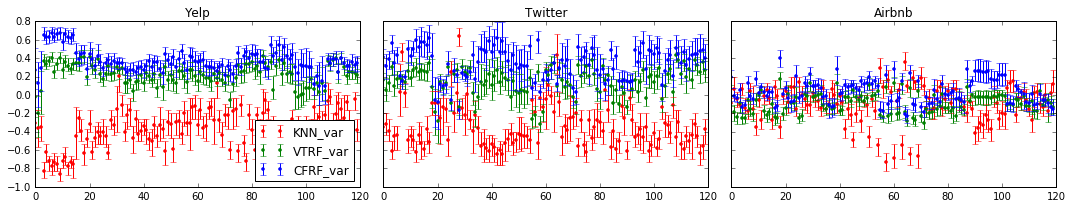

In [540]:
# without sort
var_list = ['KNN_var','VTRF_var','CFRF_var']
plot_errorbar(var_list)

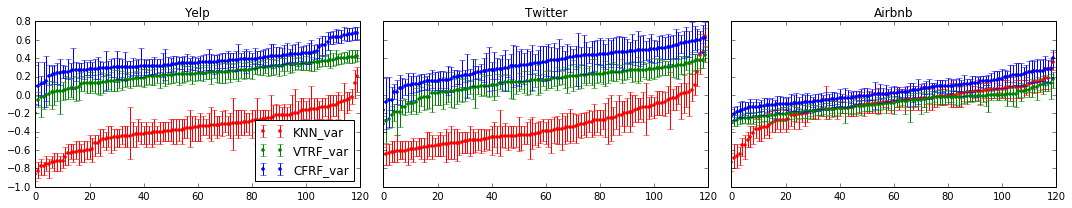

In [461]:
# after sort
var_list = ['KNN_var','VTRF_var','CFRF_var']
plot_errorbar(var_list)

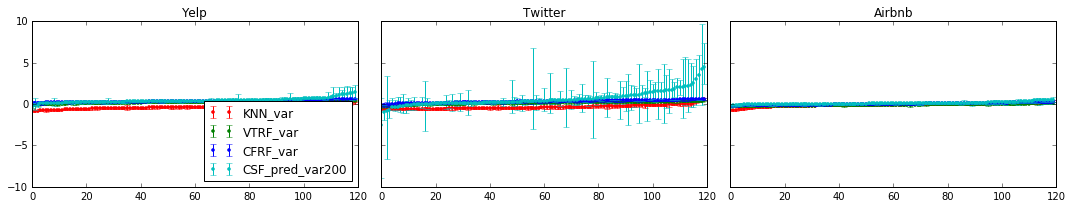

In [462]:
var_list = ['KNN_var','VTRF_var','CFRF_var','CSF_pred_var200']
plot_errorbar(var_list)

In [626]:
def avg_var():
    dataset_list = ['yp','tw','airbnb']
    all_var_info = []
    for var in ['KNN_var','VTRF_var','CFRF_var','CSF_pred_var200','CSF_pred_var2000']:
        col_var = []
        for di in range(len(dataset_list)):
            data_pd = pd.read_csv(project_path+'V2_'+full_name[dataset_list[di]].lower()+'/8_Var/'+dataset_list[di]+'_effect_var.csv')
            y_mean = []
            var_cols = data_pd[var].values
            for var_cell in var_cols:
                varv = ast.literal_eval(var_cell)
                y_mean.append(np.var(varv))
            col_var.append(float('%.3f' % (np.mean(y_mean))))
        all_var_info.append(pd.DataFrame(col_var,index=['yelp','twitter','airbnb'],columns=[var.split('_')[0]+'_meanVar']))

    for var in ['CSF_direct_var200','CSF_direct_var2000']:
        csf_var = []
        for di in range(len(dataset_list)):
            data_pd = pd.read_csv(project_path+'V2_'+full_name[dataset_list[di]].lower()+'/8_Var/'+dataset_list[di]+'_effect_var.csv')
            csf_var.append(float('%.3f' % (np.mean(data_pd[var].values))))
            
        all_var_info.append(pd.DataFrame(csf_var,index=['yelp','twitter','airbnb'],columns=[var]))
    
    concat_pd = pd.concat(all_var_info,axis=1)
    concat_pd['Mean'] = concat_pd.mean(axis=1)
    display(concat_pd.sort_values(by=['Mean']),ascending=True)


In [487]:
data_pd = pd.read_csv(project_path+'V2_twitter/8_Var/tw_effect_var.csv')
np.mean(data_pd['CSF_direct_var2000'].values)

1.676925

In [627]:
avg_var()

,KNN_meanVar,VTRF_meanVar,CFRF_meanVar,CSF_meanVar,CSF_meanVar,CSF_direct_var200,CSF_direct_var2000,Mean
airbnb,0.002,0.001,0.001,0.004,0.002,0.032,0.015,0.008143
yelp,0.003,0.001,0.002,0.013,0.005,0.135,0.068,0.032429
twitter,0.004,0.002,0.004,0.414,0.233,3.463,1.677,0.828143


In [489]:
avg_var()

,KNN_var,VTRF_var,CFRF_var,CSF_pred_var200,CSF_pred_var2000,CSF_direct_var200,CSF_direct_var2000,Mean
airbnb,-0.100229,-0.087730,0.035744,0.122805,0.123490,0.031908,0.015042,0.020147
yelp,-0.365988,0.226382,0.370021,0.460635,0.462255,0.135067,0.068075,0.193778
twitter,-0.335753,0.146304,0.337006,0.645397,0.653131,3.463217,1.676925,0.940890


### Train LR using all sentences and predict probability 
> 1. Predict probability for each source and target sentence, take probability difference <br>
> 2. Draw boxplot for sample data, x_axis=proba(x=1), y_axis=treatment effect of each method (KNN, VT, CTF, CSF) <br>
> 3. Draw boxplot for sample data, x_axis=amt_class, y_axis=proba(x=1) for each amt_class <br>

In [14]:
def train_LR_byall(data_file,vocab_file):
    """
    Train LR using all sentences from the corresponding dataset, exclude amt rated samples for out-of-bag estimation.
    Evaluate the classification performance.
    """
    dataset_list = ['yp','tw','airbnb']
    for di in range(len(dataset_list)):
        print("Processing %s ... " % (full_name[dataset_list[di]]))
        #(1) get out-of-bag training data
        data_pd = pd.DataFrame(pickle.load(open(data_file[dataset_list[di]],'rb')))
        amt_pd = pd.read_csv(project_path+'V2_'+full_name[dataset_list[di]].lower()+'/8_Var/'+dataset_list[di]+'_effect_var.csv')
        select_pd = data_pd[~data_pd['id'].isin(amt_pd['id'].values)]
        train_sentences = select_pd.sentence.values
        train_labels = select_pd.true_y.values
        
        #(2) fit LR classifier
        if(dataset_list[di] == 'airbnb'):
            my_vocab = list(set(pd.read_csv(vocab_file).word.values))
            ct_vec = CountVectorizer(min_df=3,max_df=0.9,vocabulary=my_vocab)
        else:
            ct_vec = CountVectorizer(min_df=3,max_df=0.9)
            
        X_sents = ct_vec.fit_transform(train_sentences)
        LR_clf = LogisticRegression(random_state=42,n_jobs=-1)
        LR_clf.fit(X_sents,train_labels)
        #avg_score = np.mean(cross_val_score(LR_clf, X_sents, train_labels, cv=5))
        
        #(3) Predict prob(x=1)
        X_src = ct_vec.transform(amt_pd.src_sentence.values)
        X_tar = ct_vec.transform(amt_pd.tar_sentence.values)
        src_prob = LR_clf.predict_proba(X_src)[:,list(LR_clf.classes_).index(1)]
        tar_prob = LR_clf.predict_proba(X_tar)[:,list(LR_clf.classes_).index(1)]
        tar_src_dif = tar_prob - src_prob
        amt_pd['src_prob'] = src_prob
        amt_pd['tar_prob'] = tar_prob
        amt_pd['tar_src_dif_prob'] = tar_src_dif
        
        amt_pd.to_csv(project_path+'V2_'+full_name[dataset_list[di]].lower()+'/8_Var/'+dataset_list[di]+'_effectVar_prob_byLR.csv',
                      columns = list(amt_pd.columns)+['src_prob','tar_prob','tar_src_dif_prob'],index = False)   


In [15]:
train_LR_byall(data_file,vocab_file)

Processing Yelp ... 
Processing Twitter ... 
Processing Airbnb ... 


In [15]:
def boxplot_var_prob_byLR(plot_type,flag):
    """
    Probability is predicted using LR model trained on each corresponding dataset.
    X_axis = prob(x=1) for each source sentence in samples.
    Y_axis = variance of treatment effect from 100 repeated times.
    """
    dataset_list = ['yp','tw','airbnb']
    for di in range(len(dataset_list)):
        if(flag == 'amt'):
            prob_pd = pd.read_csv(project_path+'V2_'+full_name[dataset_list[di]].lower()+'/8_Var/'+dataset_list[di]+'_effectVar_prob_byLR.csv')
            prob_pd['lr_effect'] = prob_pd['tar_src_dif_prob']
            fig,axes = plt.subplots(1,5,figsize=(15,3),sharex=True,sharey=False)
           # axes[1].set_xlabel('P(x=1)') 
            methods = ['KNN','VT','CTF','CSF','LR']
        elif(flag == 'all'):
            prob_file = project_path+'V2_'+full_name[dataset_list[di]].lower()+'/8_Var/'+dataset_list[di]+'_oob_prob_byLR.pickle'
            prob_pd = pd.DataFrame(pickle.load(open(prob_file,'rb')))
            prob_pd['src_prob'] = prob_pd['src_predict_prob']
            fig,axes = plt.subplots(1,4,figsize=(15,3),sharex=True,sharey=False)
            #axes[1].set_xlabel('P(x=1)') 
            methods = ['KNN','VT','CTF','CSF']
            
        for mi in range(len(methods)):
            if(di == 0):
                axes[mi].set_title(methods[mi]+'_effect')
            prob_pd['P(x=1)_intervals'] = prob_pd['src_prob'].apply(lambda x: int(x*10))
            if(plot_type == 'box'):
                sns.boxplot(x='P(x=1)_intervals',y=methods[mi].lower()+'_effect',data=prob_pd,ax=axes[mi])
            elif(plot_type == 'violin'):
                sns.violinplot(x='P(x=1)_intervals',y=methods[mi].lower()+'_effect',data=prob_pd,ax=axes[mi])
            axes[mi].set_xlabel('')
            axes[mi].set_ylabel('')
        axes[0].set_ylabel(full_name[dataset_list[di]])
        axes[2].set_xlabel('P(x=1)_intervals')
        #test_pd['KNN_var_list'] = test_pd['KNN_var'].apply(lambda x: ast.literal_eval(x))
        #test_pd['KNN_variance'] = test_pd['KNN_var_list'].apply(lambda x: np.var(x))



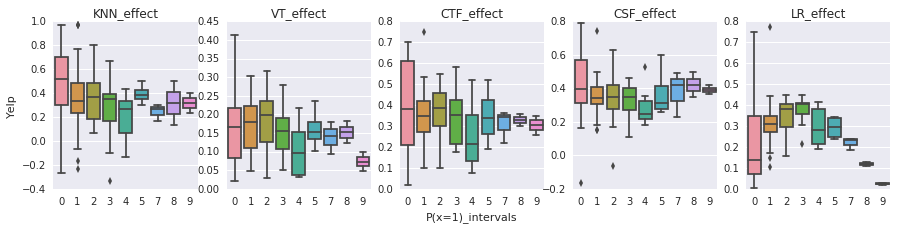

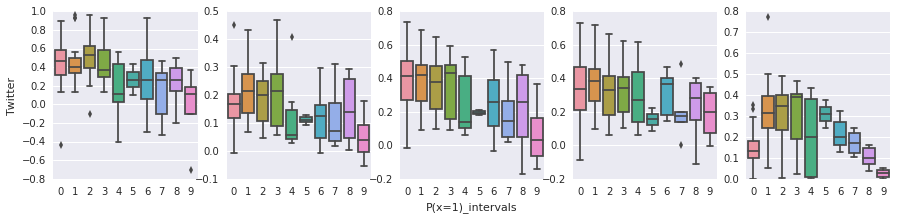

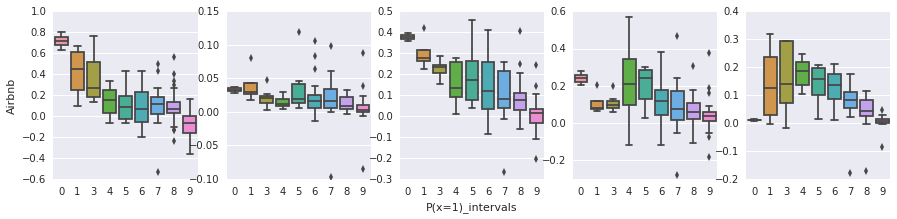

In [20]:
boxplot_var_prob_byLR(plot_type='box',flag='amt')

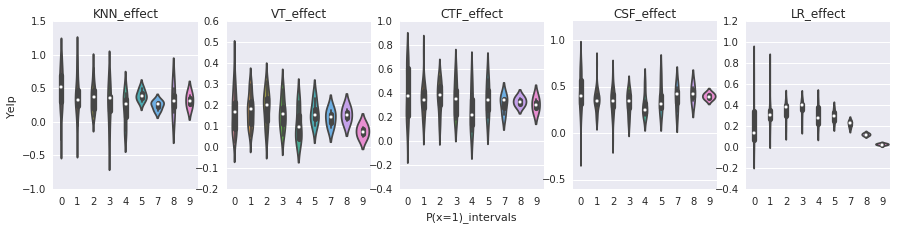

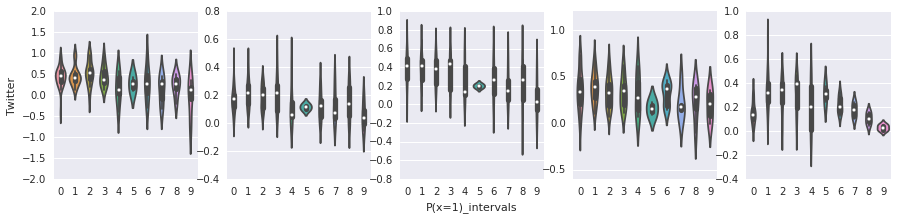

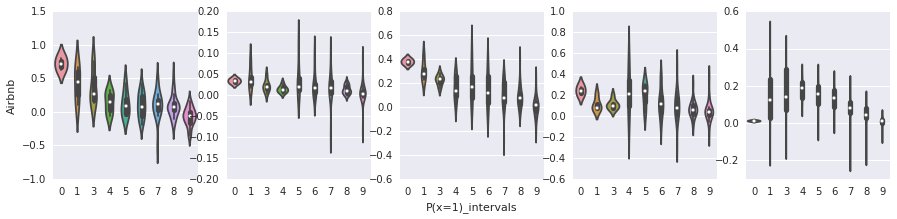

In [19]:
boxplot_var_prob_byLR(plot_type='violin',flag='amt')

In [5]:
def train_LR_predictAll(train_file,data_file,vocab_file):
    """
    Train LR using all sentences from the corresponding dataset, exclude amt rated samples for out-of-bag estimation.
    Evaluate the classification performance.
    """
    dataset_list = ['yp','tw','airbnb']
    for di in range(len(dataset_list)):
        print("Processing %s ... " % (full_name[dataset_list[di]]))
        #(1) get out-of-bag training data
        train_pd = pd.DataFrame(pickle.load(open(train_file[dataset_list[di]],'rb')))
        test_pd = pd.DataFrame(pickle.load(open(data_file[dataset_list[di]],'rb')))
        amt_pd = pd.read_csv(project_path+'V2_'+full_name[dataset_list[di]].lower()+'/8_Var/'+dataset_list[di]+'_effect_var.csv')
        train_sentences = train_pd.sentence.values
        train_labels = train_pd.label.values
        
        #(2) fit LR classifier
        if(dataset_list[di] == 'airbnb'):
            my_vocab = list(set(pd.read_csv(vocab_file).word.values))
            ct_vec = CountVectorizer(min_df=3,max_df=0.9,vocabulary=my_vocab)
        else:
            ct_vec = CountVectorizer(min_df=3,max_df=0.9)
            
        X_sents = ct_vec.fit_transform(train_sentences)
        data_vocab = ct_vec.vocabulary_
        LR_clf = LogisticRegression(random_state=42,n_jobs=-1)
        LR_clf.fit(X_sents,train_labels)
        #avg_score = np.mean(cross_val_score(LR_clf, X_sents, train_labels, cv=5))
        
        #(3) Predict prob(x=1)
        X_src = ct_vec.transform(test_pd.sentence.values)
        X_tar = X_src[:]
        src_idx = [data_vocab[srcwd] for srcwd in test_pd.source.values]
        tar_idx = [data_vocab[tarwd] for tarwd in test_pd.target.values]

# Memory error for the following code
#         X_tar[src_idx] = 0
#         X_tar[tar_idx] = 1
        
        test_pd['src_predict_prob'] = LR_clf.predict_proba(X_src)[:,list(LR_clf.classes_).index(1)]
        test_pd['tar_predict_prob'] = LR_clf.predict_proba(X_tar)[:,list(LR_clf.classes_).index(1)]
        
        #tar_prob = LR_clf.predict_proba(X_tar)[:,list(LR_clf.classes_).index(1)]
        #tar_src_dif = tar_prob - src_prob
#         amt_pd['src_prob'] = src_prob
#         amt_pd['tar_prob'] = tar_prob
#         amt_pd['tar_src_dif_prob'] = tar_src_dif
        
        pickle.dump(test_pd,open(project_path+'V2_'+full_name[dataset_list[di]].lower()+'/8_Var/'+dataset_list[di]+'_oob_prob_byLR2.pickle','wb'))
        
#         amt_pd.to_csv(project_path+'V2_'+full_name[dataset_list[di]].lower()+'/8_Var/'+dataset_list[di]+'_effectVar_prob_byLR.csv',
#                       columns = list(amt_pd.columns)+['src_prob','tar_prob','tar_src_dif_prob'],index = False)   


In [6]:
train_file = {}
train_file['yp'] = project_path + 'V2_yelp/1_Process/yp_test_containing_sents.pickle'
train_file['tw'] = project_path + 'V2_twitter/1_Process/tw_test_containing_sents.pickle'
train_file['airbnb'] = project_path + 'V2_airbnb/1_Process/airbnb_test_containing_sents.pickle'

In [8]:
start = time.time()
#train_LR_predictAll(train_file,data_file,vocab_file)
end = time.time()
print((end-start)/60)

2.181529998779297e-06


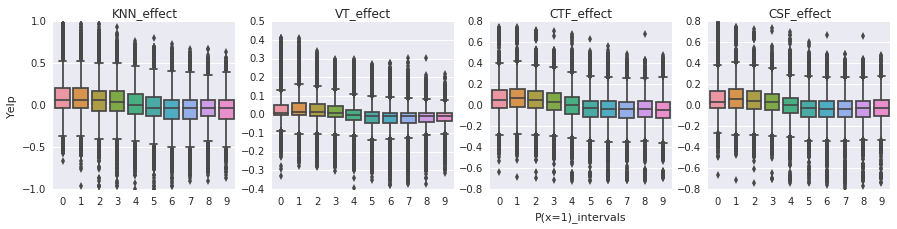

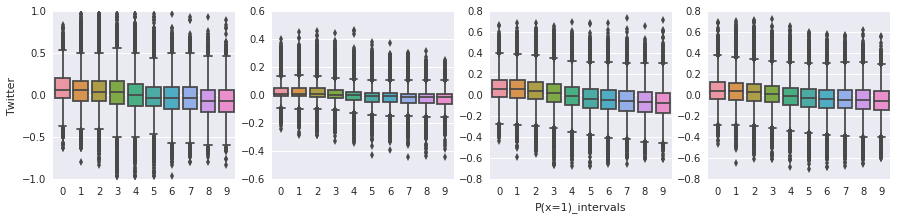

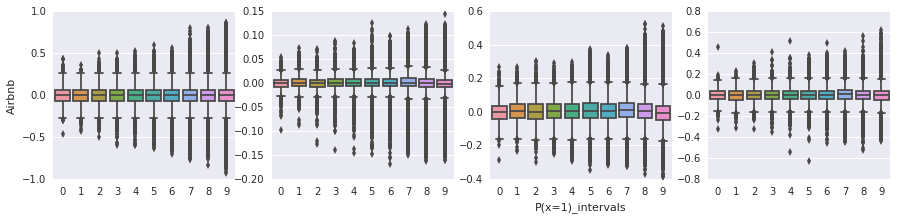

In [17]:
boxplot_var_prob_byLR(plot_type='box',flag='all')

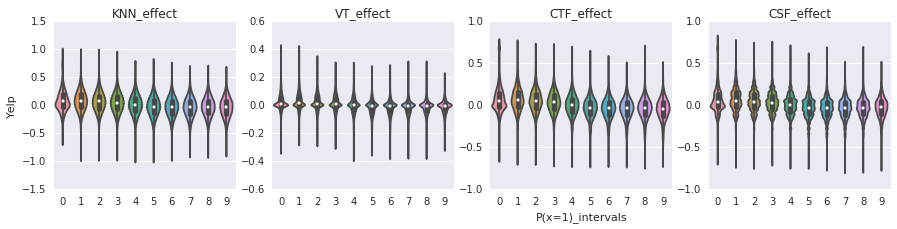

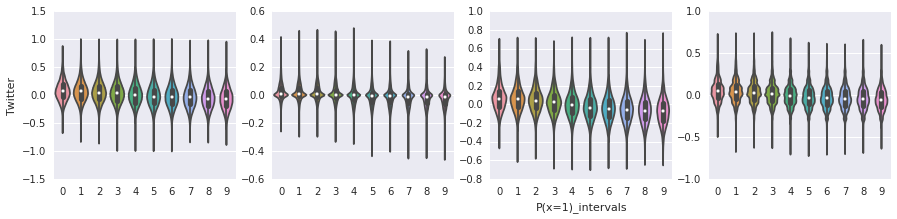

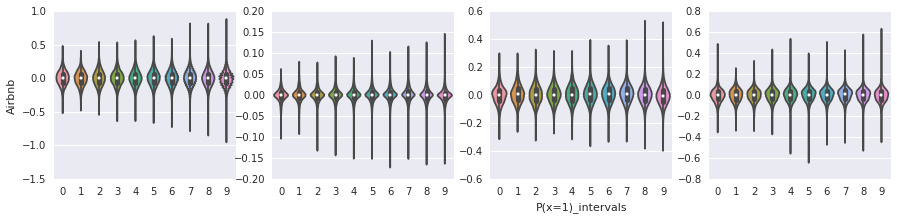

In [16]:
boxplot_var_prob_byLR(plot_type='violin',flag='all')

### Q：
> LSE distributions for each class in amt <br>
> Does high treatment effect more easy to be perceived? <br>

In [30]:
def AMT_boxplot(plot_type):
    """
    Probability is predicted using LR model trained on each corresponding dataset.
    X_axis = 3 classes of amt ratings.
    Y_axis = variance of treatment effect from KNN, VT, CTF, CSF.
    """
    dataset_list = ['yp','tw','airbnb']
    for di in range(len(dataset_list)):
        prob_pd = pd.read_csv(project_path+'V2_'+full_name[dataset_list[di]].lower()+'/8_Var/'+dataset_list[di]+'_effectVar_prob_byLR.csv')
        prob_pd['lr_effect'] = prob_pd['tar_src_dif_prob']
        prob_pd['srcprob_effect'] = prob_pd['src_prob']
        fig,axes = plt.subplots(1,6,figsize=(15,3),sharex=True,sharey=True)
        methods = ['KNN','VT','CTF','CSF','srcProb','LR']
        
        
        for mi in range(len(methods)):
            if(di == 0):
                axes[mi].set_title(methods[mi]+'_effect')
            prob_pd['AMT_perception'] = prob_pd['amt_effect_mostcom'].apply(lambda x: 1 if x>0 else (-1 if x<0 else 0))
            if(plot_type == 'box'):
                sns.boxplot(x='AMT_perception',y=methods[mi].lower()+'_effect',data=prob_pd,ax=axes[mi])
            elif(plot_type == 'violin'):
                sns.violinplot(x='AMT_perception',y=methods[mi].lower()+'_effect',data=prob_pd,ax=axes[mi])
            axes[mi].set_xlabel('')
            axes[mi].set_ylabel('')
        axes[0].set_ylabel(full_name[dataset_list[di]])
        if(di == 2):
            axes[2].set_xlabel('AMT_perception')
        #test_pd['KNN_var_list'] = test_pd['KNN_var'].apply(lambda x: ast.literal_eval(x))
        #test_pd['KNN_variance'] = test_pd['KNN_var_list'].apply(lambda x: np.var(x))



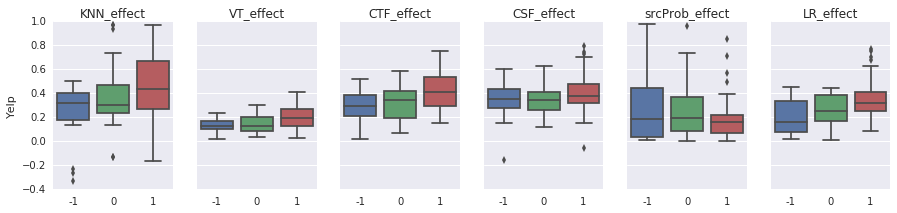

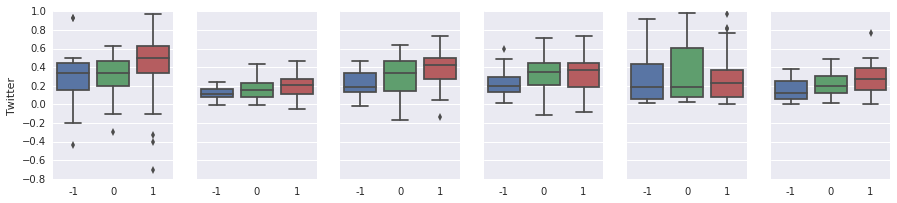

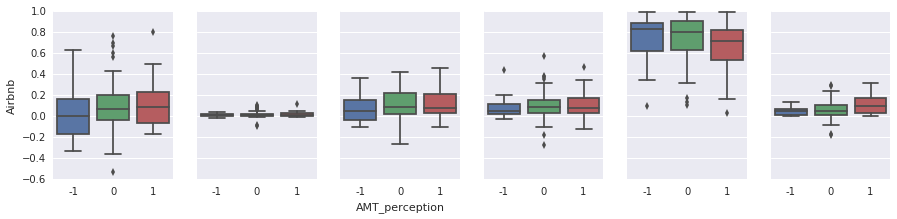

In [31]:
AMT_boxplot(plot_type='box')

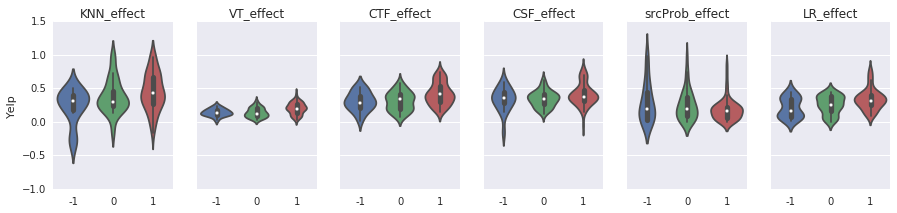

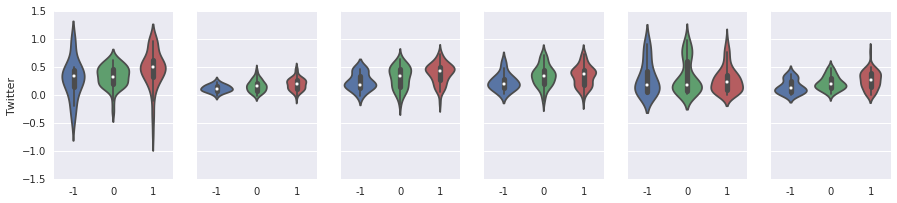

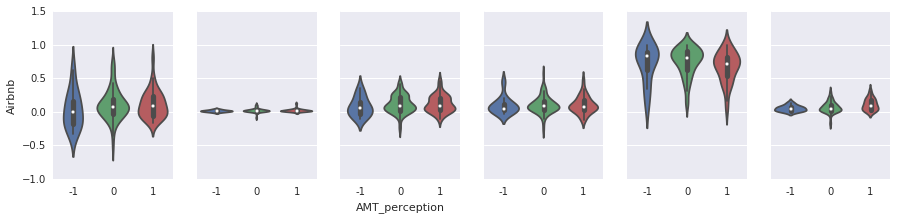

In [32]:
AMT_boxplot(plot_type='violin')

### Possible imporvements
- Increase minimal node size
- Print total number of containing sentences for each source and target word
- plot error bar